In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from os.path import join
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import unidecode
from wordcloud import WordCloud
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carlosandresosorioalcalde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [328]:
# Read the data
def read_data(path, filename):
    format_datetime_str = "%Y-%m-%dT%H:%M:%S+00:00"
    df = pd.read_csv(join(path, filename),
            sep = ';',
            parse_dates = ['date'],
            date_parser = lambda x: datetime.strptime(x, format_datetime_str)
        )
    return df

def clean_text(text, stopwords = stopwords.words('spanish')):
    # Remove special characters
    text = re.sub('\W+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove spaces
    text = text.strip()
    # Replace multiple spaces with single space
    text = re.sub(' +', ' ', text)
    # Remove accents
    text = unidecode.unidecode(text)
    # Remove stopwords
    spanish_stopwords = [unidecode.unidecode(w) for w in stopwords]
    words_without_stopwords = [w for w in text.split() if not w in spanish_stopwords]
    text = ' '.join(words_without_stopwords)

    return text 

def wordcloud(text, stopwords = None, max_words = 50):
    wordcloud = WordCloud(
        background_color='white',
        max_words=max_words,
        max_font_size=40,
        scale=5,
        random_state=42,
        stopwords = stopwords
    ).generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [329]:
# Read the data
path = '/Users/carlosandresosorioalcalde/Documents/GitHub/Analizandome'
filename = 'notas_en_blanco.csv'
df = read_data(path, filename)

In [330]:
# Delete rows with empty content
df = df[df['content'].notnull()]

# Apply the cleaner function to the content
df['clean_text'] = df['content'].map(clean_text)

# Apply the cleaner function to the title
df['clean_title'] = df['title'].map(clean_text)

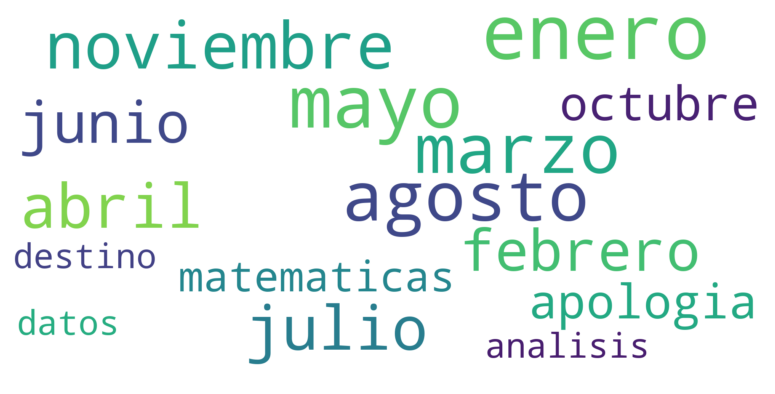

In [331]:
# Create the wordcloud for the titles
wordcloud_title = ' '.join(df['clean_title'])
wordcloud(wordcloud_title, max_words = 15)

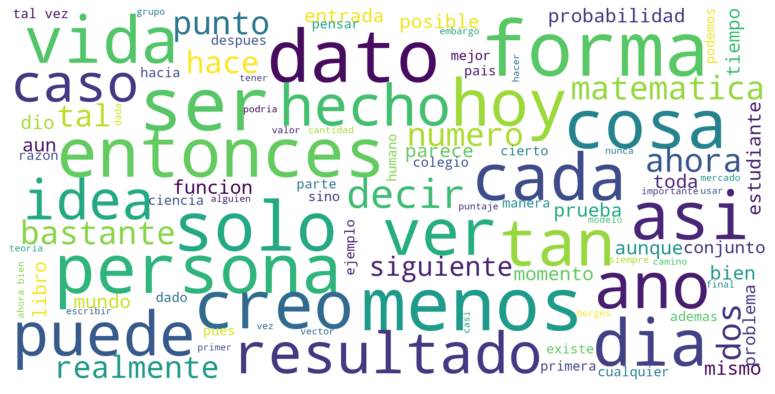

In [332]:
# Create the wordcloud for the contents
wordcloud_content = ' '.join(df['clean_text'])
wordcloud(wordcloud_content, max_words=100)

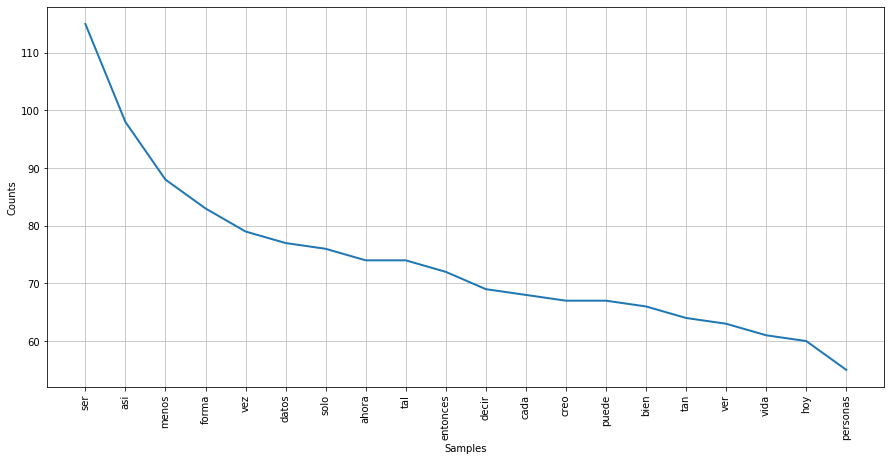

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [333]:
# Manual removing of stopwords
plt.figure(figsize=(15, 7))
nltk.FreqDist(wordcloud_content.split()).plot(20)

In [286]:
# Select manually the words that does not add value (I guess...)
manual_stopwords = ['asi', 'menos', 'vez', 'ahora', 'tal', 'entonces', 'decir', 'cada', 'bien', 'tan', 'ver', 'puede', 'creo', 'ser', 'pues', 'forma', 'solo', 'hace']

# Clean the content again with the new manual_stopwords
df['clean_text'] = df['content'].map(lambda x : clean_text(x, stopwords.words('spanish') + manual_stopwords))


# Gensim for topic modelling

In [316]:
words = df['clean_text'].map(lambda x : x.split())
id2word = corpora.Dictionary(words)

# Corpus
corpus = [id2word.doc2bow(text) for text in words]

# Topics
n_topics = 2
lda_model = gensim.models.LdaMulticore(
    corpus = corpus,
    id2word = id2word,
    num_topics = n_topics
)

In [317]:
# Print the final topics
lda_model.print_topics()

[(0,
  '0.003*"vida" + 0.003*"hoy" + 0.003*"datos" + 0.003*"aun" + 0.003*"hecho" + 0.002*"cosas" + 0.002*"personas" + 0.002*"matematicas" + 0.002*"anos" + 0.002*"realmente"'),
 (1,
  '0.004*"datos" + 0.003*"probabilidad" + 0.002*"bastante" + 0.002*"hoy" + 0.002*"personas" + 0.002*"momento" + 0.002*"vida" + 0.002*"dos" + 0.002*"cosas" + 0.002*"realmente"')]

# Sklearn LDA for topic modelling

In [322]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the contents
n_topics = 2
cv = CountVectorizer(max_df = 0.95,
    min_df = 2,
    max_features = 1000,
    stop_words = stopwords.words('spanish') + manual_stopwords
)

dtm = cv.fit_transform(df['clean_text'])
LDA = LatentDirichletAllocation(n_components = n_topics, 
    max_iter = 20, 
    learning_method = 'online', 
    learning_offset = 50., 
    random_state = 0
)

# Fit model
LDA.fit(dtm)


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=20, n_components=2, random_state=0)

In [327]:
# Print the words for each topic
for index in range(len(LDA.components_)):
    topic = LDA.components_[index]
    top_ten_words = topic.argsort()[-10:]
    topic_words = [cv.get_feature_names()[i] for i in top_ten_words]
    print('Topic {}: {}'.format(index, ', '.join(topic_words)))

Topic 0: vallejo, hacia, hoy, vida, ciencia, personas, aunque, borges, libro, aun
Topic 1: existe, bastante, probabilidad, entiendo, funcion, siguiente, cierto, numero, matematicas, datos


# Word2Vec applied to the content

In [335]:
# Create sentences for every entry of the blog
sentences = df['clean_text'].map(lambda x : x.split())

In [343]:
# Instantiate the Word2Vec model
model_w2v = Word2Vec(
    sentences, 
    window = 5, 
    min_count = 5, 
    workers = 4,
    alpha = 0.02
)

# Train the model
model_w2v.train(
    sentences,
    total_examples = model_w2v.corpus_count,
    epochs = 100
)

(990044, 1879600)

In [361]:
words_to_analyze = [
    'matematicas',
    'vida',
    'futuro'
]
for word in words_to_analyze:
    similar_words = [word[0] for word in model_w2v.wv.most_similar(word)]
    print('{}: {}'.format(word, ', '.join(similar_words)))

matematicas: bastante, buena, tesis, real, descubri, pregrado, estudio, carrera, formas, profesor
vida: suficientemente, persona, optica, camino, conocida, parecia, futuro, ser, decision, intentar
futuro: recordar, decisiones, pequeno, formas, alla, tristeza, merece, cambio, unica, ojos
